# Titanic Top 4% with ensemble modeling

# 1. Introduction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

# 2. Load and check data
## 2.1 Load data
- load train and test data

In [2]:
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')
IDtest = test['PassengerId']

## 2.2 Outlier detection
- outlier의 경우, 예측(특히 regression 문제)에 있어서 그 영향이 크기 때문에 따로 핸들링하는 것
- 아래 코드에선 outlier detection을 위해 Tukey method를 사용
- Tukey method : interquartile 범위가 1Q와 3Q 값 사이로 구성되어 outlier는 (IQR +- outlier step) 범위 밖의 값에 해당됨
- numerical features인 (Age, SibSp, Parch, Fare)에 대해서 outlier를 detection하도록 작성

In [3]:
def detect_outliers(df, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col], 75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature 'col'
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        
        # append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n)
    
    return multiple_outliers

# detect outliers from Age, SibSp, Parch and Fare
Outliers_to_drop = detect_outliers(train, 2, ['Age', 'SibSp', 'Parch', 'Fare'])

In [4]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


- 10개의 outlier가 도출되었으며 outlier로 도출된 이유는,
- 1) PassengerId가 28, 29, 342인 승객은 높은 요금(Fare)의 티켓을 가짐
- 2) 그 이외의 7명은 SibSp 값이 높음

#### Drop outliers

In [5]:
train = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

## 2.3 Joining train and test set
- Join train and test datasets in order to obtain the same number of features during categorical conversion
- feature engineering에서 categorical conversion하는 동안 동일한 개수의 feature를 갖기 위해 train, test 데이터 합침

In [6]:
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

## 2.4 Check for null and missing values

- Age와 Cabin의 많은 값이 null 값임
- Survived가 null인 것은 test 데이터 때문임 (타겟 값인 'Survived'의 값이 test 데이터 셋엔 없음)

In [7]:
# Fill empty and Nans values with NaN
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [8]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [9]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

#### Summarize and statistics

In [11]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


# 3. Feature analysis
## 3.1 Numerical values

- 첫 번째 열을 통해 Survived와 다른 Feature 간의 상관관계를 파악해보자면, Fare만이 의미있는 상관관계를 가진 듯 보임
- 그렇다고 다른 features 가 쓸모없다는 건 아님. 이 feature들을 모아서 부분 모집단을 만들면 '생존'과 상관있을 수도 있음

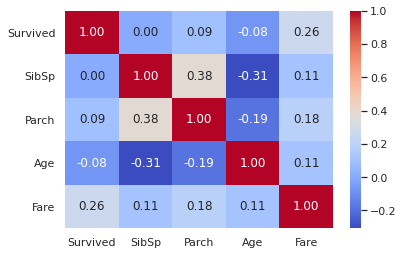

In [12]:
# Correlation matrix between numerical values (Sibsp, Parch, Age and Fare values) and Survived
g = sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot=True, fmt='.2f', cmap='coolwarm')

#### SibSp
- 형제자매/배우자가 많은 승객이 SibSp=0인 승객보다 생존 확률이 높음
- 다만 SibSp가 3 이상인 승객의 경우, 그렇지 않은 승객보다 생존 확률 낮음

/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


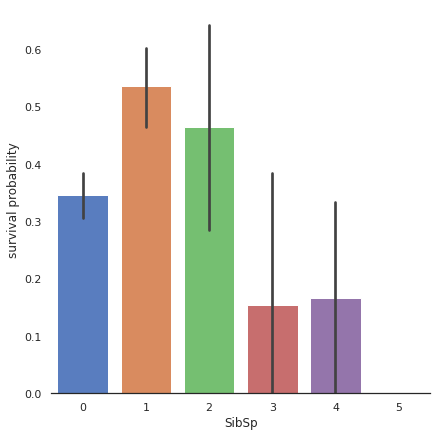

In [13]:
# Explore SibSp feature vs Survived
g = sns.factorplot(x='SibSp', y='Survived', data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

#### Parch
- 혼자이거나 3명 이상의 대가족보다는 소가족일수록 생존 확률이 높았음
- Parch=3인 경우, 생존율의 표준편차가 컸음

/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


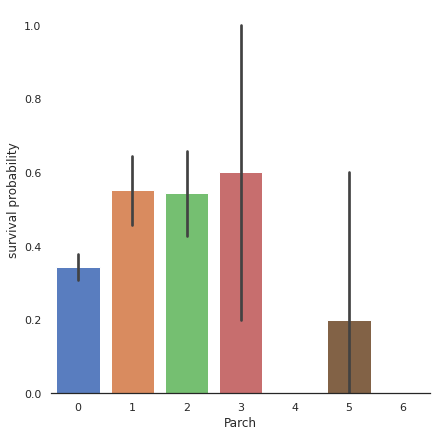

In [14]:
# Explore Parch feature vs Suvived
g = sns.factorplot(x='Parch', y='Survived', data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

#### Age
- 'Age' feature의 분포는 가우시안 분포(Gaussian distribution) 같은 꼬리 분포(tailed distribution)를 가짐
- 생존 여부에 따라(0 or 1) Age는 두 subpopultaions(부분 모집단)에서 다른 형태의 분포를 보임
- → 젋은(어린) 승객이 생존한 경우가 많았고, 60-80 세의 경우 더 적게 생존함
- 'Age'가 'Survived'와 상관관계가 없을지라도, 승객의 나이에 따라 생존 확률이 달라짐을 알 수 있음 (나이가 아주 어리면 생존 확률이 높음)

/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


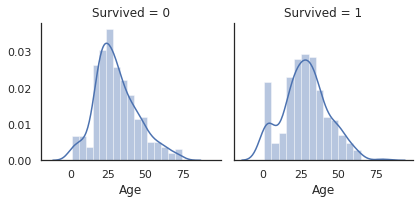

In [15]:
# Explore Age vs Survived
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, 'Age')

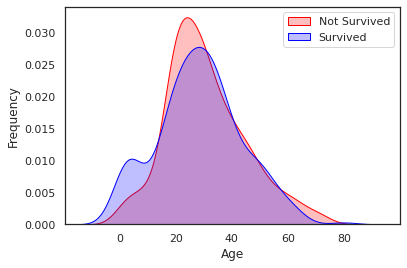

In [16]:
# Explore Age distribution
g = sns.kdeplot(train['Age'][(train['Survived']==0) & (train['Age'].notnull())], color='Red', shade=True)
g = sns.kdeplot(train['Age'][(train['Survived']==1) & (train['Age'].notnull())], color='Blue', shade=True, ax=g)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived', 'Survived'])

- 위 kdeplot에서 두 밀도(?)를 겹쳐놨을 때, 생존한 승객(파란색) 중 0과 5사이의 peak 점을 볼 수 있음

#### Fare

In [17]:
dataset['Fare'].isnull().sum()

1

#### Fill Fare missing values with the median value
- 하나의 결측치만 있기 때문에 Fare feature의 중간 값으로 채움

In [18]:
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

#### Explore Fare distribution

/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


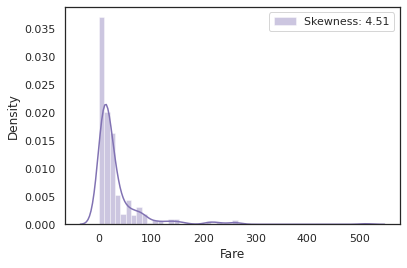

In [19]:
g = sns.distplot(dataset['Fare'], color='m', label='Skewness: %.2f' % (dataset['Fare'].skew()))
g = g.legend(loc='best')

- Fare 분포가 매우 치우친 형태이므로 로그 함수를 사용해서 치우침 정도를 완화한다.

In [20]:
# Apply log to Fare to reduce skewness distribution
dataset['Fare'] = dataset['Fare'].map(lambda i: np.log(i) if i > 0  else 0)

/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


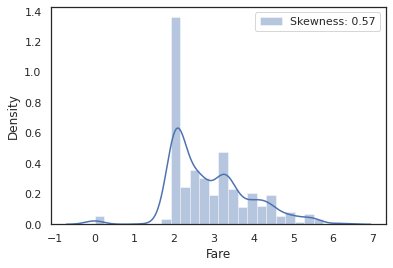

In [21]:
g = sns.distplot(dataset['Fare'], color='b', label='Skewness: %.2f' % (dataset['Fare'].skew()))
g = g.legend(loc='best')

## 3.2 Categorical values

#### Sex

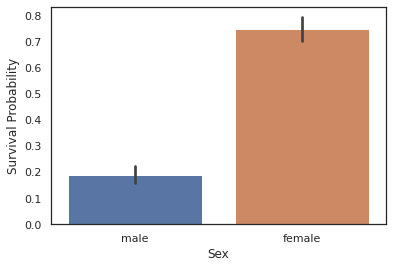

In [22]:
g = sns.barplot(x='Sex', y='Survived', data=train)
g = g.set_ylabel('Survival Probability')

In [23]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


- 남성의 경우, 여성보다 훨씬 적게 생존함
- 따라서 성별이 생존을 예측하는 중요한 역할을 할 것

#### Pclass

/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


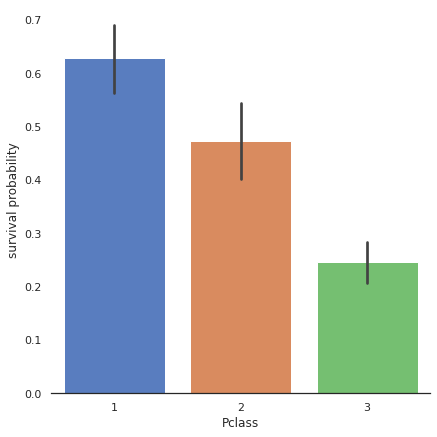

In [24]:
# Explore Pclass vs Survived
g = sns.factorplot(x='Pclass', y='Survived', data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


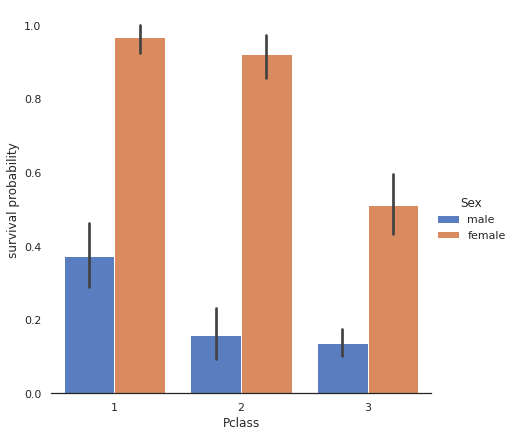

In [25]:
# Explore Pclass vs Survived by Sex
g = sns.factorplot(x='Pclass', y='Survived', hue='Sex', data=train, size=6, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

- 승객의 생존률은 Pclass 값마다 달랐고, Pclass=1인 승객들의 생존 확률이 가장 높음

#### Embarked

In [26]:
dataset['Embarked'].isnull().sum()

2

#### Fill Embarked nan values of dataset set with 'S' most frequent value
- 'Embarked' feature의 경우, 결측치가 2개이므로 결측치로 최빈값인 'S'를 대체

In [27]:
dataset['Embarked'] = dataset['Embarked'].fillna('S')

/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


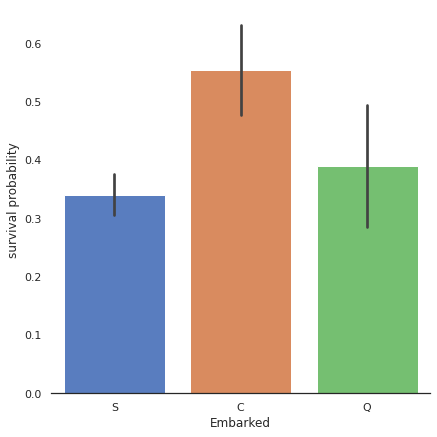

In [28]:
# Explore Embarked vs Survived
g = sns.factorplot(x='Embarked', y='Survived', data=train, size=6, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

- Cherbourg (C)에서 온 승객의 생존 확률이 가장 높았음
- 이를 통해 Pclass=1인 승객이 Queenstown(Q), Southampton (S)보다 C에서 많이 탑승했다고 가정해볼 수 있음
- → Pclass=1인 경우에 생존율이 높았으니까

/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


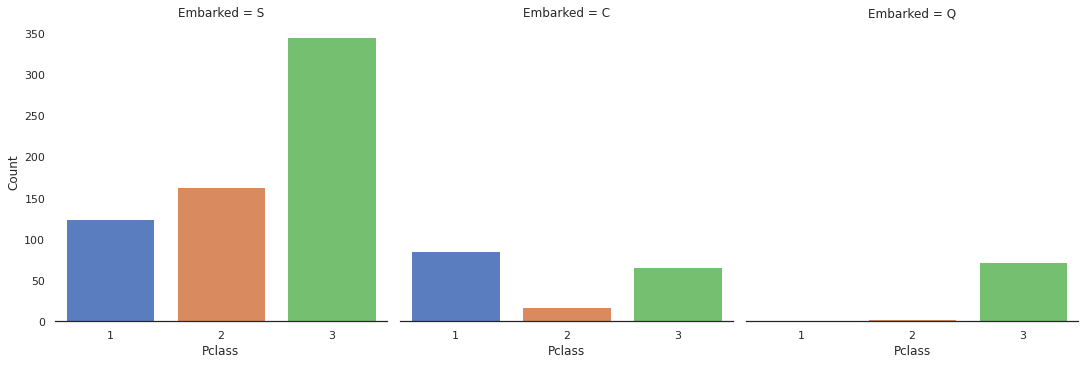

In [29]:
# Explore Pclass vs Embarked
g = sns.factorplot('Pclass', col='Embarked', data=train, kind='count', palette='muted')
g.despine(left=True)
g = g.set_ylabels('Count')

- S, Q는 Pclass=3인 승객이 대부분이고, C는 생존 확률이 가장 높은 Pclass=1인 승객이 절반을 차지함
- → 즉, C에서 생존율이 높았던 이유는 C의 탑승객 중 Pclass=1인 승객의 비율 때문
- 여기서 Pclass=1인 승객의 생존 확률이 높은 이유를 설명할 수 없지만, 하나의 가설은 Pclass=1인 승객이 구조 당시 우선순위가 더 높았다는 것

# 4. Filling missing Values
## 4.1 Age

- Age의 결측치를 채우기 위해 Age feature와 다른 features 간의 상관관계 살펴보기

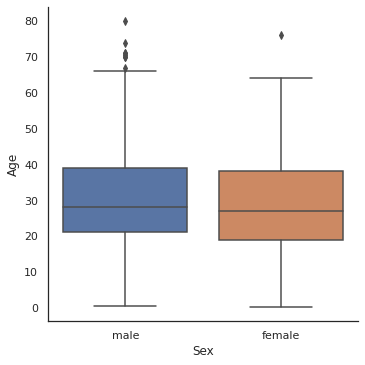

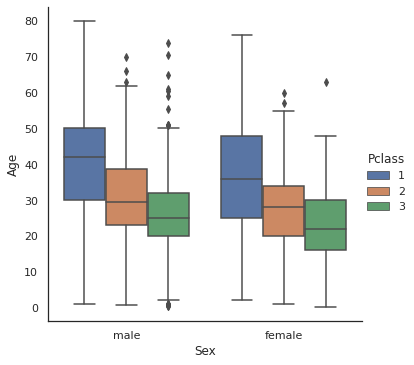

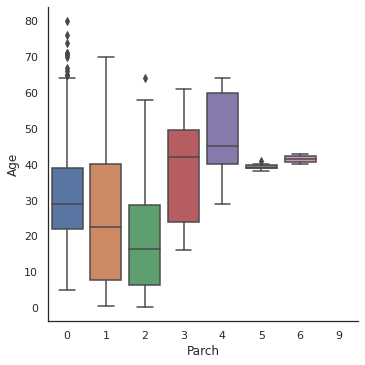

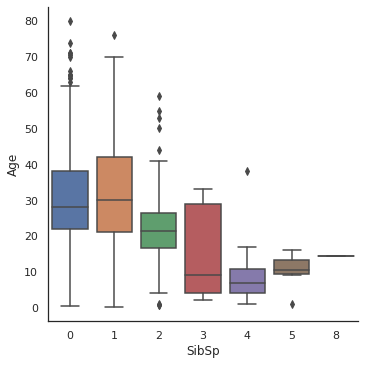

In [30]:
# Explore Age vs Sex, Pclass, Parch and SibSp
g = sns.catplot(y='Age', x='Sex', data=dataset, kind='box')
g = sns.catplot(y='Age', x='Sex', hue='Pclass', data=dataset, kind='box')
g = sns.catplot(y='Age', x='Parch', data=dataset, kind='box')
g = sns.catplot(y='Age', x='SibSp', data=dataset, kind='box')

- 나이의 분포는 남녀 비슷한 형태이므로 'Sex' feature는 나이를 예측하는 데 의미있는 정보를 주지는 못할 것
- 반면, Pclass=1인 승객은 Pclass=2 or 3인 승객보다 나이가 많음

In [31]:
# convert Sex into categorical value 0 for male and 1 for female
dataset['Sex'] = dataset['Sex'].map({'male':0, 'female':1})

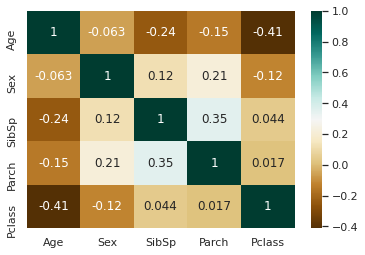

In [32]:
g = sns.heatmap(dataset[['Age', 'Sex', 'SibSp', 'Parch', 'Pclass']].corr(), cmap='BrBG', annot=True)

- Age는 'Sex'와 상관관계가 (거의) 없지만 SibSp, Parch, Pclass와는 음의 상관관계를 가짐
- Age-Parch plot에서 Parch가 증가할수록 Age도 증가하지만, 일반적인 상관관계는 음의 상관관계
- 따라서 Age의 결측치를 처리하기 위해 해당 feature와 상관관계를 갖는 SibSp, Parch, Pclass를 활용

In [33]:
# Filling missing value of Age

## Fill Age with the median age of similar rows accroding to Pclass, Parch and SibSp
# Index of NaN age rows

# 데이터프레임 원본을 사용하여 데이터를 처리(iloc 등)하면 settingwithcopywarning이 발생할 수 있음
# copy()를 사용하거나 pd.options.mode.chained_assignment = None을 선언하면 됨

pd.options.mode.chained_assignment = None

index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)
for i in index_NaN_age:
    age_med = dataset['Age'].median()
    age_pred  = dataset['Age'][((dataset['SibSp']==dataset.iloc[i]['SibSp']) & (dataset['Parch']==dataset.iloc[i]['Parch']) & (dataset['Pclass']==dataset.iloc[i]['Pclass']))].median()
    if not np.isnan(age_pred):
        dataset['Age'].iloc[i] = age_pred
    else:
        dataset['Age'].iloc[i] = age_med

/usr/local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


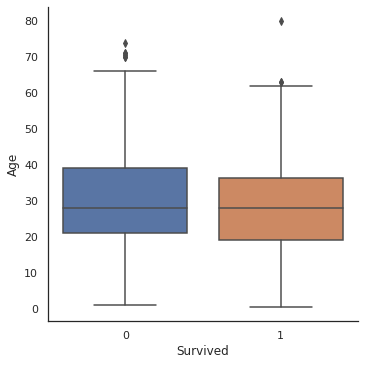

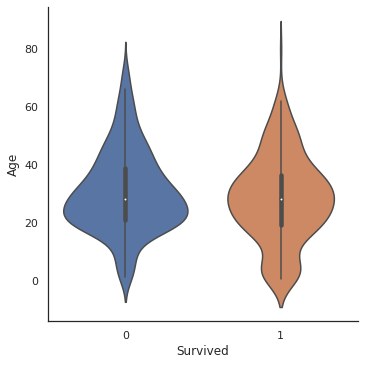

In [34]:
g = sns.factorplot(x='Survived', y='Age', data=train, kind='box')
g = sns.factorplot(x='Survived', y='Age', data=train, kind='violin')

- Age의 중간값은 Survived=0과 Survived=1에서 차이가 없음
- Survived=1인 violin plot을 보면 제일 어린 연령 층의 생존 확률이 높음을 알 수 있음

# 5. Feature engineering
## 5.1 Name/Title

In [35]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [36]:
# Get Title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset['Name']]
dataset['Title'] = pd.Series(dataset_title)
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

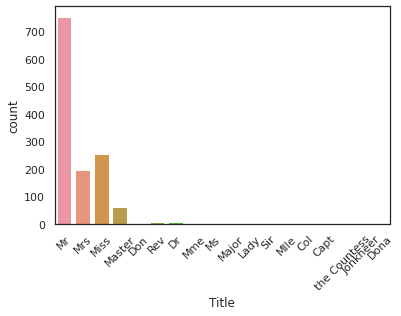

In [37]:
g = sns.countplot(x='Title', data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

#### Convert to categorical values Title
- 총 17 개의 Title이 있고, 이를 다시 4개의 카테고리로 통합

In [38]:
dataset['Title'] = dataset['Title'].replace(['Lady', 'the Countess', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset['Title'] = dataset['Title'].map({'Master':0, 'Miss':1, 'Ms':1, 'Mme':1, 'Mlle':1, 'Mrs':1, 'Mr':2, 'Rare':3})
dataset['Title'] = dataset['Title'].astype(int)

/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


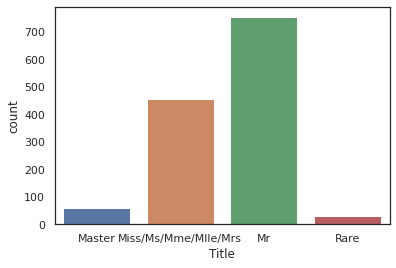

In [39]:
g = sns.countplot(dataset['Title'])
g = g.set_xticklabels(['Master', 'Miss/Ms/Mme/Mlle/Mrs', 'Mr', 'Rare'])

/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


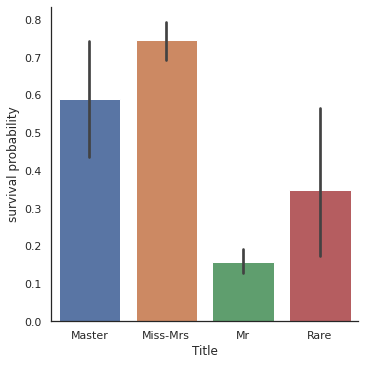

In [40]:
g = sns.factorplot(x='Title', y='Survived', data=dataset, kind='bar')
g = g.set_xticklabels(['Master', 'Miss-Mrs', 'Mr', 'Rare'])
g = g.set_ylabels('survival probability')

#### Drop Name variable

In [41]:
dataset.drop(labels=['Name'], axis=1, inplace=True)

## 5.2 Family Size
- 가족 수가 많을수록 구조가 힘들 수 있}음. 형제/자매/부모 등을 구조하느라 자신의 우선순위가 밀릴 수 있으므로
- 이와 관련하여 'Fize'라는 feature를 만들어 가족 수와 생존 확률이 연관되었는지 확인해본다.

In [42]:
# Create a family size descriptor from SibSp and Parch
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1

/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


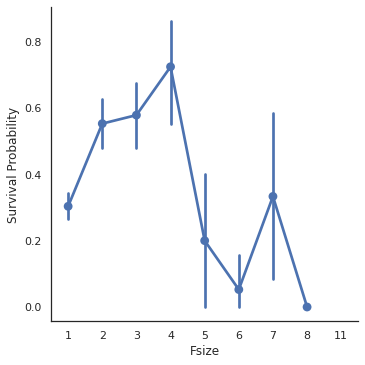

In [43]:
g = sns.factorplot(x='Fsize', y='Survived', data=dataset)
g = g.set_ylabels('Survival Probability')

- 가족의 크기가 생존율에 영향을 미치는 요인으로 보임 → 5명 이상의 대가족이면 생존율이 현저히 떨어짐
- 추가적으로 가족 크기에 관한 4개의 카테고리 추가

In [44]:
# Create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if s == 2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if 5 <= s else 0)

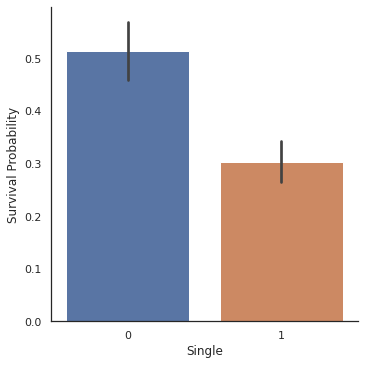

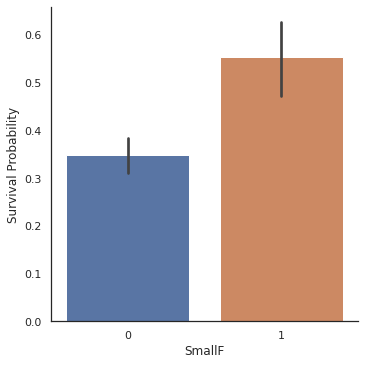

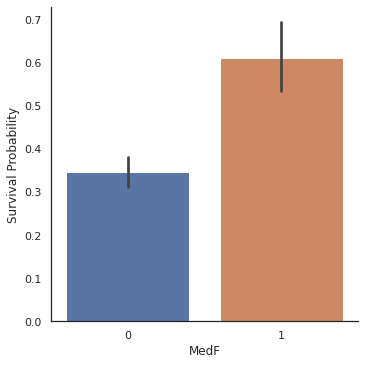

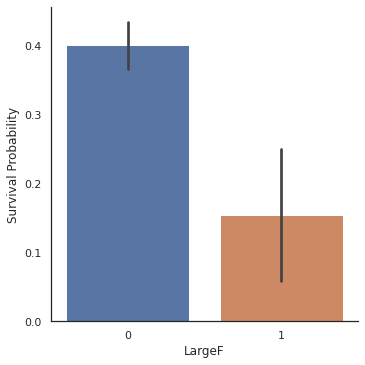

In [45]:
g = sns.catplot(x='Single', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival Probability')

g = sns.catplot(x='SmallF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival Probability')

g = sns.catplot(x='MedF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival Probability')

g = sns.catplot(x='LargeF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival Probability')

- 위 plot 결과에서 알 수 있듯이, small 및 medium 가족들은 single이나 large 가족보다 생존 확률이 높았음

In [46]:
# convert to indicator values Title and Embarked
dataset = pd.get_dummies(dataset, columns=['Title'])
dataset = pd.get_dummies(dataset, columns=['Embarked'], prefix='Em')

In [47]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


## 5.3 Cabin

In [48]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [49]:
dataset['Cabin'].describe()

count                 292
unique                186
top       B57 B59 B63 B66
freq                    5
Name: Cabin, dtype: object

In [50]:
dataset['Cabin'].isnull().sum()

1007

In [51]:
dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [52]:
# Replace the Cabin number by the type of cabin 'X' if not
dataset['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


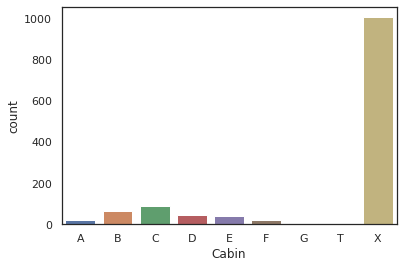

In [53]:
g = sns.countplot(dataset['Cabin'], order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'])

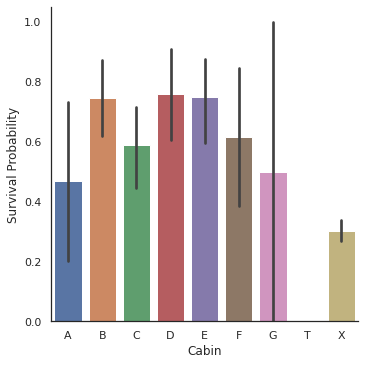

In [54]:
g = sns.catplot(y='Survived', x='Cabin', data=dataset, kind='bar', order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'])
g = g.set_ylabels('Survival Probability')

- cabin(객실)이 있는 승객이 적기 때문에, 생존율은 중요한(?) 표준편차를 갖고, desk(프런트)가 다른 승객들의 생존율을 구별할 수 없음 
- 일반적으로 객실이 있는 승객이 객실이 없는 승객(X)보다는 생존 확률 높음

In [55]:
dataset = pd.get_dummies(dataset, columns=['Cabin'], prefix='Cabin')

## 5.4 Ticket

In [56]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

- 같은 prefix의 'Ticket' 은 cabin을 함께 예약했다는 의미이므로 같은 위치의 객실에 있었다는 의미이기도 함
- 따라서 prefix가 같다면 class와 생존 확률이 유사할 것

In [57]:
# Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X.

Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit():
        Ticket.append(i.replace('.', '').replace('/', '').strip().split(' ')[0]) # Take prefix
    else:
        Ticket.append('X')
dataset['Ticket'] = Ticket
dataset['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [58]:
dataset = pd.get_dummies(dataset, columns=['Ticket'], prefix='T')

In [59]:
# Create categorical values for Pclass
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns=['Pclass'], prefix='Pc')

In [60]:
# Drop useless variables
dataset.drop(labels=['PassengerId'], axis=1, inplace=True)

In [61]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


# 6. Modeling

In [62]:
## Separate train dataset and test dataset
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=['Survived'], axis=1, inplace=True)

In [63]:
## Separate train features and label
train['Survived'] = train['Survived'].astype(int)
Y_train = train['Survived']
X_train = train.drop(labels=['Survived'], axis=1)

## 6.1 Simple Modeling
### 6.1.1 Cross Validate models
- 10개의 유명한 분류기를 사용하여 각 분류기의 평균 정확도를 측정
    - 1) 서포트 벡터 머신(SVC)
    - 2) 결정 나무(Decision Tree)
    - 3) AdaBoost
    - 4) Gradient Boosting
    - 5) 랜덤포레스트(Random Forest)
    - 6) Extra Trees
    - 7) Multi Layer Perceptron(neural network)
    - 8) KNN
    - 9) Logistic regression
    - 10) Linear Discriminant Analysis

In [64]:
# Cross validate models with kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


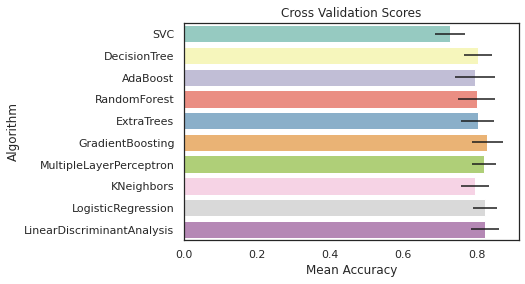

In [65]:
# Modeling step Test differents algorithms
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state, learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y=Y_train, scoring='accuracy', cv=kfold, n_jobs=4))
    
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_res = pd.DataFrame({'CrossValMeans': cv_means, 'CrossValerrors': cv_std, 
                       'Algorithm':['SVC','DecisionTree','AdaBoost','RandomForest','ExtraTrees','GradientBoosting','MultipleLayerPerceptron',
                                   'KNeighbors','LogisticRegression','LinearDiscriminantAnalysis']})

g = sns.barplot('CrossValMeans', 'Algorithm', data=cv_res, palette='Set3', orient='h', **{'xerr': cv_std})
g.set_xlabel('Mean Accuracy')
g = g.set_title('Cross Validation Scores')

- 앙상블 모델링을 위해 SVC, AdaBoost, RandomForest, ExtraTrees, GradientBoosting 분류기를 선택

### 6.1.2 Hyper-parameter tunning for best models
- 위에 언급된 4개의 분류기를 최적화하기 위해 grid search를 수행
- n_jobs는 cpu 개수에 따라 결정됨. 만약 cpu가 4개면 n_jobs=4로 설정

In [81]:
### META MODELING WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

# Adaboost
DTC = DecisionTreeClassifier()
adaDTC = AdaBoostClassifier(DTC, random_state=7)
ada_param_grid = {'base_estimator__criterion': ['gini', 'entropy'],
                 'base_estimator__splitter': ['best', 'random'],
                 'algorithm': ['SAMME', 'SAMME.R'],
                 'n_estimators': [1,2],
                 'learning_rate': [0.0001, 0.001, 0.01, 01., 0.2, 0.3, 1.5]}

gsadaDTC = GridSearchCV(adaDTC, param_grid=ada_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsadaDTC.fit(X_train, Y_train)
ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


In [68]:
gsadaDTC.best_score_

0.8241317671092953

In [82]:
# ExtraTrees
ExtC = ExtraTreesClassifier()

# Search grid for optimal prameters
ex_param_grid = {'max_depth': [None],
                'max_features': [1, 3, 10],
                'min_samples_split': [2, 3, 10],
                'min_samples_leaf': [1, 3, 10],
                'bootstrap': [False],
                'n_estimators': [100, 300],
                'criterion': ['gini']}

gsExtC = GridSearchCV(ExtC, param_grid=ex_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)

gsExtC.fit(X_train, Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.832035240040858

In [70]:
# RFC Parameters tunning
RFC = RandomForestClassifier()

# Search grid for optimal prameters
rf_param_grid = {'max_depth': [None],
                'max_features': [1, 3, 10],
                'min_samples_split': [2, 3, 10],
                'min_samples_leaf': [1, 3, 10],
                'bootstrap': [False],
                'n_estimators': [100, 300],
                'criterion': ['gini']}

gsRFC = GridSearchCV(RFC, param_grid=rf_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)

gsRFC.fit(X_train, Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8342824310520939

In [71]:
# Gradient boosting tunning
GBC = GradientBoostingClassifier()

# Search grid for optimal prameters
gb_param_grid = { 'loss': ['deviance'],
                'n_estimators': [100, 200, 300],
                'learning_rate': [0.1, 0.05, 0.01],
                'max_depth': [4, 8],
                'min_samples_leaf': [100, 150],
                'max_features': [0.3, 0.1]}

gsGBC = GridSearchCV(GBC, param_grid=gb_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsGBC.fit(X_train, Y_train)
GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


0.8319969356486212

In [72]:
# SVC classifier
SVMC = SVC(probability=True)

# Search grid for optimal prameters
svc_param_grid = {'kernel': ['rbf'],
                 'gamma': [0.001, 0.01, 0.1, 1],
                 'C': [1, 10, 50, 100, 200, 300, 1000]}

gsSVMC = GridSearchCV(SVMC, param_grid=svc_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsSVMC.fit(X_train, Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.8331332992849847

### 6.1.3 Plot learning curves
- learning curve는 train 데이터 셋에 과대적합(overfitting)이 있는지, 정확도에 있어서 training 크기의 영향을 알아볼 수 있는 지표

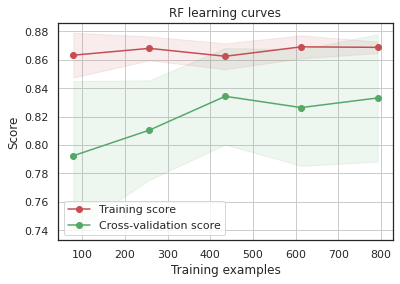

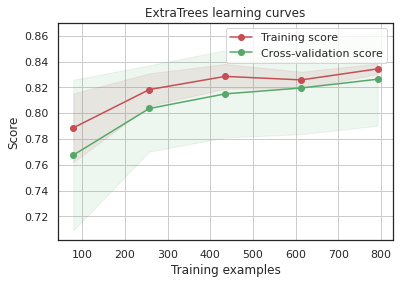

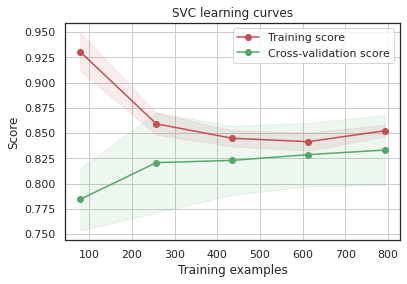

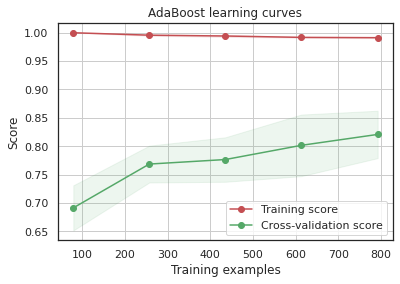

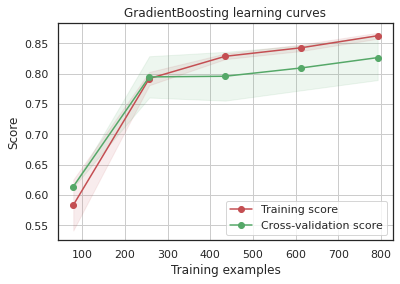

In [73]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """ Generate a simple plot of the test and train learning curve """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    plt.legend(loc='best')
    
    return plt

g = plot_learning_curve(gsRFC.best_estimator_, 'RF learning curves', X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_, 'ExtraTrees learning curves', X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_, 'SVC learning curves', X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_, 'AdaBoost learning curves', X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_, 'GradientBoosting learning curves', X_train, Y_train, cv=kfold)

- GradientBoosting, AdaBoost 분류기는 train 데이터 셋에 대해 오버피팅되는 경향을 보임
- 따라서 cross-validation이 진행되면서 GradientBoosting과 Adaboost는 더 많은 training 예제에서 좋은 성능을 보임
- SVC와 ExtraTrees 분류기는 training과 cross-validation 커브가 점점 더 가까워지므로 예측을 더 일반화(?)하는 경향이 있음

### 6.1.4 Feature importance of tree based classifiers

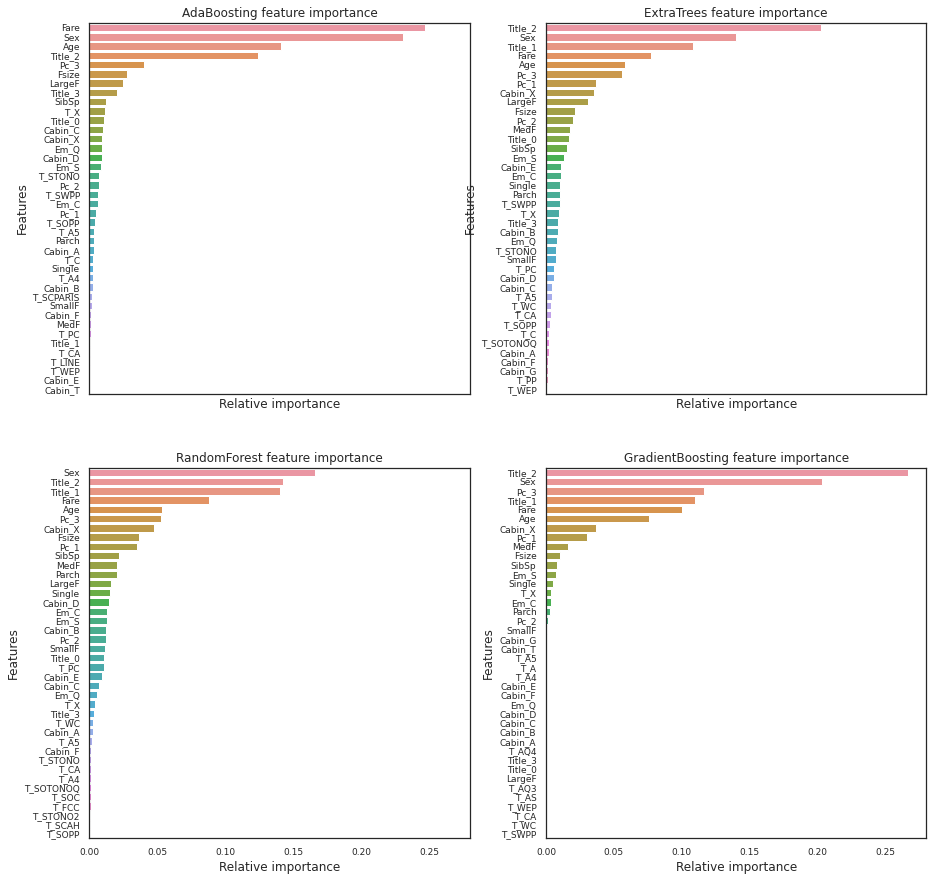

In [83]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex='all', figsize=(15,15))

names_classifiers=[('AdaBoosting', ada_best), ('ExtraTrees', ExtC_best), ('RandomForest', RFC_best), ('GradientBoosting', GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40], x=classifier.feature_importances_[indices][:40], orient='h', ax=axes[row][col])
        g.set_xlabel('Relative importance', fontsize=12)
        g.set_ylabel('Features', fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

- 상대적 중요도에 따라 분류기는 서로 다른 top feature importance를 가짐. 이는 각 분류기의 예측 결과가 같은 feature를 기반으로 두지 않음을 의미
- 그럼에도 불구하고, 공통된 중요 feature가 있는데, 예를 들면 'Fare', 'Title_2', 'Age', 'Sex'가 있다.
- Title_2는 Mrs/Mlle/Mme/Miss/Ms이며, 이는 성별과 밀접한 관련이 있다.

- Feature 별 의미
    - 1) Pc_1, Pc_2, Pc_3, Fare : 승객의 일반적인 사회적 지위
    - 2) Sex, Title_2, TItle_3(Mr) : 성별
    - 3) Age, Title_1 (Master) : 승객의 나이
    - 4) Fsize, LargeF, MedF, Single : 승객의 가족 규모

- 4가지 분류기의 feature importance에 따르면, 생존률 예측은 배 안에서의 위치보다는 나이, 성별, 가족, 사회적 지위와 더 관련있는 것처럼 보임

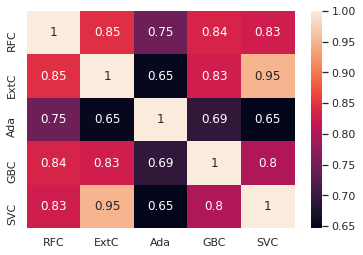

In [77]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name='RFC')
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name='ExtC')
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name='SVC')
test_Survived_AdaC = pd.Series(ada_best.predict(test), name='Ada')
test_Survived_GBC = pd.Series(GBC_best.predict(test), name='GBC')

# Concatenate all classfier results
ensemble_results = pd.concat([test_Survived_RFC, test_Survived_ExtC, test_Survived_AdaC, test_Survived_GBC, test_Survived_SVMC], axis=1)

g = sns.heatmap(ensemble_results.corr(), annot=True)

- AdaBoost를 제외하곤 분류기들이 서로 꽤 비슷한 예측 결과를 냄
- 5개 예측 결과 간의 조금씩 다른 점이 있으므로, 이는 앙상블 보트를 고려하기에 충분함

## 6.2 Ensemble modeling

### 6.2.1 Combining models
- 5개 분류기의 예측 결과를 합치기 위해 voting classifier를 사용
- voting 파라미터 값이 'soft'인 것은 각 vote의 확률을 고려하겠다는 의미

In [79]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best), ('svc', SVMC_best), ('adac', ada_best), ('gbc', GBC_best)], voting='soft', n_jobs=4)
votingC = votingC.fit(X_train, Y_train)

## 6.3 Prediction
## 6.3.1 Predict and Submit results

In [80]:
test_Survived = pd.Series(votingC.predict(test), name='Survived')
results = pd.concat([IDtest, test_Survived], axis=1)
results.to_csv('ensemble_python_voting.csv', index=False)